# Datos de los ligandos

## Obtención de los datos de los ligandos  cocristalizados con CDK2 desde Pubchem y Chembl

**Esta libreta tiene como objetivo extraer datos de las moléculas cocristalizadas con la proteína CDK2 a partir de las bases de datos CheMBL y PubChem**

> Puntos clave de esta libreta:
- Se extrae de la tabla de datos principal de la proteína las conformaciones que poseen a algún ligando en el sitio activo.
- Se crea un set de moléculas usando identificador PDB de cada molécula (cada molécula es designada con un id de 3 letras).
- Se usa el id de cada molécula (LIG) para obtener los datos de la página `http://www.rcsb.org/ligand/LIG`, correspondiente a cada ligando. Con ello obtenemos:
    - El smile isomérico de la molécula.
    - El InChI
    - El InChI Key
- Usamos el **InChI** para obtener los datos de cada molécula desde _**PUBCHEM**_ y _**CHEMBL**_.
- Guardamos los datos en un diccionario y a su vez lo exportamos a un archivo pinckle.

### Importamos algunas librerías iniciales

In [1]:
import pandas as pd
import numpy as np
import glob, os, sys
# Añadimos la ruta del directorio raíz para tener acceso a los archivos y módulos
sys.path.append(r'..')

## Cargamos los datos de la tabla principal

Nombre de la proteína:

In [2]:
# Nombre de la proteina de interes
prot_name = 'cdk2'

Cargamos el dataframe principal de la proteína:

In [3]:
# Este es el DF que no tiene aun afgregados los valores AUC de las conformaciones
patho_to_json_file = glob.glob((os.path.join('..', 'data', 
                        F'TABLA_MTDATA_{prot_name.upper()}_*_crys_LIGS_INFO.json')))[0]
                      
df_prot_labels = pd.read_json(patho_to_json_file)
df_prot_labels.shape

(402, 14)

**Esta tabla contiene ya la información de la molécula presente en el sitio activo de cada conformación de la proteína**

In [4]:
df_prot_labels.head(3)

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs,Inhib,Inhib_mass
1aq1,human cyclin dependent kinase 2 complexed with...,1997-11-12,1,A,2.0,298,92.953020,2,"[9, 14]","[[36, 44], [149, 162]]",1,[STU],STU,440.0
1b38,human cyclin-dependent kinase 2,1998-12-23,1,A,2.0,298,97.315436,1,[9],"[[36, 44]]",3,"[ACE, ATP, MG]",ATP,398.0
1b39,human cyclin-dependent kinase 2 phosphorylated...,1998-12-23,1,A,2.1,298,97.315436,1,[9],"[[36, 44]]",3,"[ACE, ATP, MG]",ATP,398.0


## Identificación de los inhibidores
### Seleccionamos las conformaciones que posean algun inhibidor

In [5]:
filtro_inh = df_prot_labels.Inhib.notnull()
df_ligs_crys = df_prot_labels[filtro_inh]

In [6]:
# Número total de conformaciones con algún ligando en el sitio activo
df_ligs_crys.shape

(365, 14)

### Identificamos el número de ligandos únicos

In [7]:
ligs_crys_prot = set(df_ligs_crys.Inhib)
len(ligs_crys_prot)

315

## Comenzamos la obtención de los datos
El proceso es el siguiente:
> 1. Con el identificador de la molécula del PDB (nombe de tres letras, por ejemplo: ATP) se busca en el PDB la información de dicha molécula: http://www.rcsb.org/ligand
2. Se obtiene el *chemicalInChIKey*, el *chemicalInChI* y el SMILES isomérico de la molécula.
3. El *InChI el *InChIKey* o en su defecto el SMILES isimérico, es usado para buscar a la molécula en las bases de datos PubChem y Chembl.
    - Dichos *request* a la la API de cada base de datos se hacen con las librerías **_chembl_webresource_client_** y **_pubchemy_**.
4. Todos los datos disponibles de las moléculas son guardados en un diccionario de pyhton.
5. Finalmente el objeto se guarda en un archivo para posteriormente poder tener acceso al mismo.


### Web scrapping de los ligandos

In [8]:
# Librerías útiles para el web scrapping de los ligandos
import urllib.request
from bs4 import BeautifulSoup
from chembl_webresource_client.new_client import new_client
import pubchempy

In [9]:
# Url para accesar a la información de los ligandos en el PDB
URL_PDB = 'http://www.rcsb.org/ligand'

### Obtenemos los datos de cada ligando y los guardamos en un diccionario

In [10]:
# Generamos un diccionario con los datos de la molécula
dic_ligs_crys_prot = {}

for ligando in ligs_crys_prot:
    url_lig = F'{URL_PDB}/{ligando}'
    print(F'Procesando al ligando: {ligando}\n')
    
    # Extraemos los datos del html del ligando:
    lig_data = urllib.request.urlopen( url_lig ).read().decode()
    
    # Extraemos del bsoup los siguientes datos:
    # InChIKey
    soup = BeautifulSoup(lig_data)
    inchi_key = soup.find("tr", {"id": "chemicalInChIKey"})
    inchi_key_str = inchi_key.find('td').text
    
    # InChI
    inchi = soup.find("tr", {"id": "chemicalInChI"})
    inchi_str = inchi.find('td').text
    
    # isomeric SMILE (por si no se encuentra en la API de PbCh)
    smiles = soup.find("tr", {"id": "chemicalIsomeric"})
    smiles_str = smiles.find('td').text
    
    # Peso molecular
    mw = soup.find("tr", {"id": "chemicalMolecularWeight"})
    mw_str = mw.find('td').text
    
    # Con los datos anteriores usamos la librería para accesar al Chembl
    # **** CHEMBL ****
    # Procedemos a extraer los datos del Chembl
    molecule = new_client.molecule
    try:
        chblMol_info = molecule.get(inchi_key_str)
        chembl_id = chblMol_info['molecule_chembl_id']
    except:
        print(F'No se pudo obtener infor de CHEMBL: {ligando}')
        print(inchi_str + '\n')
        chblMol_info = None
        chembl_id = None
        
    # Ahora obtenemos datos correspondientes a pubchem
    # *** PUBCHEM ***
    try:
        pbch_mol = pubchempy.get_compounds(inchi_str, 'inchi')[0]
        pbch_cid = pbch_mol.cid
        pbch_data = pbch_mol.to_dict()
        canonical_smiles = pbch_mol.canonical_smiles
    except:
        print(F'Fallo con datos PUBCHEM: {ligando}')
        pbch_mol = None
        pbch_cid = None
        pbch_data = None
        canonical_smiles = None
    # Creamos la entrada para el diccionario
    # Primero el diccionario del ligando
    dic_lig = {'inchi_key': inchi_key_str,
               'inchi': inchi_str,
               'molecular_weight': float(mw_str),
               'canonical_smiles': canonical_smiles,
               'isomeric_similes': smiles_str,
               'chembl_id': chembl_id,
               'chembl_data': chblMol_info,
               'pubchem_id': pbch_cid,
               'pubchem_data': pbch_data,}
    
    # Anidamos el dict  del ligando al dic principal
    dic_ligs_crys_prot[ligando] = dic_lig

Procesando al ligando: CK2

Procesando al ligando: 3TI

Procesando al ligando: 62K

No se pudo obtener infor de CEHMBL: 62K
InChI=1S/C19H20N4O5S/c1-11(2)10-28-19(25)12-3-8-16-15(9-12)17(18(24)21-16)23-22-13-4-6-14(7-5-13)29(20,26)27/h3-9,11,22H,10H2,1-2H3,(H2,20,26,27)(H,21,23,24)

Procesando al ligando: FC8

Procesando al ligando: CT6

No se pudo obtener infor de CEHMBL: CT6
InChI=1S/C18H14BrN5/c19-15-3-1-2-14(10-15)16-11-18(24-17(23-16)6-9-22-24)21-12-13-4-7-20-8-5-13/h1-11H,12H2,(H,21,22,23)/p+1

Procesando al ligando: TIY

Procesando al ligando: ATP

Procesando al ligando: 4CK

Procesando al ligando: LZ1

Procesando al ligando: 6QB

Procesando al ligando: LIA

Procesando al ligando: U55

No se pudo obtener infor de CEHMBL: U55
InChI=1S/C10H11N5O2S/c11-9-5-10(14-6-13-9)15-7-1-3-8(4-2-7)18(12,16)17/h1-6H,(H2,12,16,17)(H3,11,13,14,15)

Procesando al ligando: X63

No se pudo obtener infor de CEHMBL: X63
InChI=1S/C14H17N7O4/c15-13(23)9-3-12(21(24)25)11(17-1-2-22)4-10(9)18-5-8-6-19-14(16

Procesando al ligando: 46K

Procesando al ligando: X1N

No se pudo obtener infor de CEHMBL: X1N
InChI=1S/C16H13N5O2S/c1-9-18-13-6-5-10-8-17-16(20-14(10)15(13)24-9)19-11-3-2-4-12(7-11)21(22)23/h2,4,7-8H,3,5-6H2,1H3/b19-11-

Procesando al ligando: X06

No se pudo obtener infor de CEHMBL: X06
InChI=1S/C9H8ClN5O/c10-4-1-2-6(16)5(3-4)7-13-8(11)15-9(12)14-7/h1-3,16H,(H4,11,12,13,14,15)

Procesando al ligando: 292

Procesando al ligando: SCX

No se pudo obtener infor de CEHMBL: SCX
InChI=1S/C19H17F2N7/c1-2-12-10-26-28-16(23-7-11-8-24-19(22)25-9-11)6-15(27-18(12)28)17-13(20)4-3-5-14(17)21/h3-6,8-10,23H,2,7H2,1H3,(H2,22,24,25)

Procesando al ligando: X66

Procesando al ligando: 6AF

No se pudo obtener infor de CEHMBL: 6AF
InChI=1S/C17H21BrN4O3S/c1-10(23)11(2)25-16-15(18)9-20-17(22-16)21-12-3-5-13(6-4-12)26(19,24)14-7-8-14/h3-6,9-11,14,19,23H,7-8H2,1-2H3,(H,20,21,22)/t10-,11-,26+/m1/s1

Procesando al ligando: FAP

No se pudo obtener infor de CEHMBL: FAP
InChI=1S/C21H23F2N5O2/c1-28(2)11-15(29)12-

No se pudo obtener infor de CEHMBL: FAL
InChI=1S/C21H23Cl2N5O2/c1-28(2)12-16(29)13-30-17-6-4-15(5-7-17)25-21-24-10-9-20(27-21)26-19-11-14(22)3-8-18(19)23/h3-11,16,29H,12-13H2,1-2H3,(H2,24,25,26,27)/t16-/m1/s1

Procesando al ligando: LZ8

Procesando al ligando: Z02

Procesando al ligando: CDK

No se pudo obtener infor de CEHMBL: CDK
InChI=1S/C18H21N5O4S2/c1-12-16(28-18(24)23(12)2)15-8-9-19-17(22-15)21-13-4-6-14(7-5-13)29(25,26)20-10-11-27-3/h4-9,20H,10-11H2,1-3H3,(H,19,21,22)

Procesando al ligando: 628

Procesando al ligando: A28

Procesando al ligando: X44

Procesando al ligando: 04Z

Procesando al ligando: 2AN

Procesando al ligando: PY8

Procesando al ligando: X07

Procesando al ligando: 25Z

Procesando al ligando: 61K

Procesando al ligando: RFZ

Procesando al ligando: X72

No se pudo obtener infor de CEHMBL: X72
InChI=1S/C12H10ClN5O3/c13-9-2-10(17-5-7-3-15-6-16-4-7)8(12(14)19)1-11(9)18(20)21/h1-4,6,17H,5H2,(H2,14,19)

Procesando al ligando: WXV

No se pudo obtener infor de CEHMBL:

Procesando al ligando: X73

No se pudo obtener infor de CEHMBL: X73
InChI=1S/C13H11ClN4O3/c14-12-4-1-8(7-17-12)6-16-11-3-2-9(18(20)21)5-10(11)13(15)19/h1-5,7,16H,6H2,(H2,15,19)

Procesando al ligando: F18

No se pudo obtener infor de CEHMBL: F18
InChI=1S/C9H10N6O/c10-8-7(9(11)15-14-8)13-12-5-1-3-6(16)4-2-5/h1-4,16H,(H5,10,11,14,15)/b13-12-

Procesando al ligando: B98

Procesando al ligando: 6ZK

Procesando al ligando: 07Z

Procesando al ligando: X69

No se pudo obtener infor de CEHMBL: X69
InChI=1S/C14H14N4O4/c1-22-13-6-11(17-8-9-3-2-4-16-7-9)10(14(15)19)5-12(13)18(20)21/h2-7,17H,8H2,1H3,(H2,15,19)

Procesando al ligando: 27Z

Procesando al ligando: N20

Procesando al ligando: X14

No se pudo obtener infor de CEHMBL: X14
InChI=1S/C20H28N4O3S/c1-4-20(2,3)14-7-10-17-16(11-14)18(24-23-17)19(25)22-12-13-5-8-15(9-6-13)28(21,26)27/h5-6,8-9,14H,4,7,10-12H2,1-3H3,(H,22,25)(H,23,24)(H2,21,26,27)/t14-/m1/s1

Procesando al ligando: 1PU

Procesando al ligando: 3SC

No se pudo obtener infor de CEHM

## Guardamos el set de datos en formato *pickle*

In [11]:
import pickle

In [12]:
nombre_archivo = os.path.join('..','data', 'LIGS_CDK2_crys_pubchem_chembl_data.pkl')
if not os.path.exists(nombre_archivo):
    with open(nombre_archivo, 'wb') as dic_file:
        pickle.dump(dic_ligs_crys_prot, dic_file, protocol=pickle.HIGHEST_PROTOCOL)
else:
    print("El archivo ya ha sido creado.")

### Lectura del del archivo guardado

In [13]:
# Lectura del diccionario con pickle
nombre_archivo = os.path.join('..','data', 'LIGS_CDK2_crys_pubchem_chembl_data.pkl')
with open(nombre_archivo, 'rb') as dic_file:
    dic_ligs_crys_prot = pickle.load(open(nombre_archivo, 'rb'))

In [14]:
# Número de ligandos procesados
len(dic_ligs_crys_prot)

315

# Finalmente:
## Uso del diccionario final
A modo de ejemplo visualizamos algunos de los datos disponibles en el diccionario:

In [15]:
import rdkit as rd

RDKit WARNING: [11:49:18] Enabling RDKit 2019.09.1 jupyter extensions


ID Chembl: CHEMBL14249
cid Pubchem: 5957
Nombre: ADENOSINE TRIPHOSPHATE


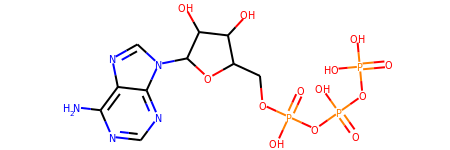

In [16]:
# Obtención del un ligando a través de una conformación
lig_1aq1 = df_ligs_crys.loc['1fin', 'Inhib']
# Imprimimos su nombre y otros datos interesantes
lig_1aq1_data = dic_ligs_crys_prot[lig_1aq1]
print(F'ID Chembl: {lig_1aq1_data["chembl_id"]}')
print(F'cid Pubchem: {lig_1aq1_data["pubchem_id"]}')
print(F'Nombre: {lig_1aq1_data["chembl_data"]["pref_name"]}')
# Obtenemos el smiles canonico
lig_1aq1_smiles = dic_ligs_crys_prot[lig_1aq1]['canonical_smiles']
# Lo visualizamos con rdkit
rd.Chem.MolFromSmiles(lig_1aq1_smiles)

ID Chembl: CHEMBL388978
Cid Pubchem: 44259
Nombre: STAUROSPORINE


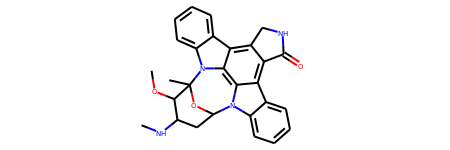

In [17]:
# Obtención del un ligando a través de una conformación
lig_1aq1 = df_ligs_crys.loc['1aq1', 'Inhib']
# Imprimimos su nombre y otros datos interesantes
lig_1aq1_data = dic_ligs_crys_prot[lig_1aq1]
print(F'ID Chembl: {lig_1aq1_data["chembl_id"]}')
print(F'Cid Pubchem: {lig_1aq1_data["pubchem_id"]}')
print(F'Nombre: {lig_1aq1_data["chembl_data"]["pref_name"]}')
# Obtenemos el smiles canonico
lig_1aq1_smiles = dic_ligs_crys_prot[lig_1aq1]['canonical_smiles']
# Lo visualizamos con rdkit
rd.Chem.MolFromSmiles(lig_1aq1_smiles)

# ¡Terminado!